# **DA5401 – Assignment 7: Model Selection** 

***Name:** Aaradhya Dashore*  
***Roll Number:** ME22B089*

### Objective:
This assignment focuses on model selection techniques using the Landsat Satellite dataset. The goal is to implement multiple classification algorithms, evaluate their performance, and determine the most suitable model for the given data. The dataset contains 36 spectral features derived from 3×3 pixel neighborhoods, and the task is to predict the land-cover class of the central pixel.

---


## Part A: Data Preparation and Baseline

In this section, the Landsat dataset is imported and prepared for analysis.  
The dataset comprises 36 spectral attributes and a single target label.  
The steps performed include:
1. Importing the training and testing data files.
2. Assigning descriptive column names.
3. Inspecting dataset dimensions and structure.
4. Extracting features and corresponding class labels.


In [5]:
# ===== Part A: Data Preparation =====

import pandas as pd
import numpy as np

# Load the training and testing datasets
train_path = "sat.trn"
test_path = "sat.tst"

# Define column names (36 features + 1 label)
col_names = [f"X{i}" for i in range(1, 37)] + ["label"]

# Read the datasets
train_df = pd.read_csv(train_path, sep="\\s+", header=None, names=col_names)
test_df = pd.read_csv(test_path, sep="\\s+", header=None, names=col_names)

# Display dataset information
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)
print("\nClass Distribution (Training Set):\n", train_df["label"].value_counts().sort_index())

# Display sample records
train_df.head()


Training Data Shape: (4435, 37)
Testing Data Shape: (2000, 37)

Class Distribution (Training Set):
 label
1    1072
2     479
3     961
4     415
5     470
7    1038
Name: count, dtype: int64


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X28,X29,X30,X31,X32,X33,X34,X35,X36,label
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


### Part A1: Data Normalization

To ensure consistent scaling across all features, the data is standardized using the `StandardScaler` from `sklearn.preprocessing`. This transformation centers the features around zero mean and scales them to unit variance, which improves the performance and convergence of several classification algorithms.


In [3]:
# ===== Part A1: Data Normalization =====

from sklearn.preprocessing import StandardScaler

# Separate features and labels
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data normalization completed successfully.")
print("Training feature matrix shape:", X_train_scaled.shape)
print("Testing feature matrix shape:", X_test_scaled.shape)


Data normalization completed successfully.
Training feature matrix shape: (4435, 36)
Testing feature matrix shape: (2000, 36)


### Part A2: Train–Test Split

The Landsat Satellite dataset is already provided as two separate files:
- `sat.trn` — Training dataset  
- `sat.tst` — Testing dataset  

These files are predefined by the dataset authors and represent fixed training and testing partitions.  
Hence, no additional splitting (such as using `train_test_split()`) is required.  
This ensures consistency and reproducibility of results across different models and experiments.

From the data preparation step:
- `X_train_scaled`, `y_train` correspond to the training set (`sat.trn`)  
- `X_test_scaled`, `y_test` correspond to the testing set (`sat.tst`)  

These will be directly used in the next step for model training.


### Part A3: Model Training

In this section, six classification algorithms are instantiated and trained on the standardized training dataset.  
Each model is fitted using the preprocessed training features (`X_train_scaled`) and corresponding class labels (`y_train`).  
The trained estimators will be evaluated on the testing data in the next section.

The models implemented are:
1. K-Nearest Neighbours (KNN)  
2. Decision Tree Classifier  
3. Dummy Classifier (Prior)  
4. Logistic Regression  
5. Naive Bayes (Gaussian)  
6. Support Vector Machine (SVC)

All models are initialized with deterministic random seeds where applicable to ensure reproducibility.


In [7]:
# ===== Part A3: Model Training =====

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings

# Suppress non-critical warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning)

# Instantiate exactly the six models as per the assignment
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "DummyClassifier": DummyClassifier(strategy='prior', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, kernel='rbf', random_state=42)
}

# Train each model on the training data
fitted_models = {}
for name, clf in models.items():
    print(f"Training: {name} ...", end=" ")
    clf.fit(X_train_scaled, y_train)
    fitted_models[name] = clf
    print("done.")

# Display summary of trained models
print("\nTrained Models:")
for i, name in enumerate(fitted_models.keys(), 1):
    print(f"{i}. {name}")

# Expose fitted models for the next part
models = fitted_models


Training: KNN ... done.
Training: DecisionTree ... done.
Training: DummyClassifier ... done.
Training: LogisticRegression ... done.
Training: GaussianNB ... done.
Training: SVC ... done.

Trained Models:
1. KNN
2. DecisionTree
3. DummyClassifier
4. LogisticRegression
5. GaussianNB
6. SVC


### Part A4: Baseline Evaluation

In this part, the trained models are evaluated on the test dataset to establish baseline performance. The evaluation metrics used are **Accuracy** and **Weighted F1-score**, which provide an overview of each model’s predictive capability and its ability to handle class imbalances. The results are compiled into a comparative table for clarity and further analysis.


In [8]:
# ===== Part A4: Baseline Evaluation =====

from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Initialize list to store evaluation results
results = []

# Evaluate each trained model on the test dataset
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Weighted F1-Score": round(f1_w, 4)
    })

# Convert results to DataFrame and sort by Weighted F1-Score
results_df = pd.DataFrame(results).sort_values(by="Weighted F1-Score", ascending=False).reset_index(drop=True)

# Display the evaluation summary
print("=== Baseline Evaluation Results ===")
display(results_df)


=== Baseline Evaluation Results ===


,Model,Accuracy,Weighted F1-Score
0,KNN,0.9045,0.9037
1,SVC,0.8955,0.8925
2,DecisionTree,0.8505,0.8509
3,LogisticRegression,0.8395,0.8296
4,GaussianNB,0.7965,0.8036
5,DummyClassifier,0.2305,0.0864


---

## Part B: ROC Analysis for Model Selection

### Part B1: Multi-Class ROC Calculation

In a multi-class classification setting, the **One-vs-Rest (OvR)** approach is used to extend the concept of the ROC curve and AUC metric, which are originally defined for binary problems.

Under the OvR scheme:
- Each class is treated as the *positive* class once, while the remaining classes are collectively treated as the *negative* class.
- For each class, a binary ROC curve is computed by comparing the predicted probabilities against the true binary labels for that class.
- The **Area Under the Curve (AUC)** is then calculated for each class individually.
- To summarize model performance across all classes, the AUC values are averaged using either a **macro-average** (simple mean across classes) or a **weighted-average** (weighted by class frequency).

This approach allows us to quantify how well each model distinguishes between classes in a multi-class context.


In [9]:
# ===== Part B1: Multi-Class ROC Calculation =====

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd

# Binarize the true labels for multi-class ROC calculation
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

roc_results = []

# Compute macro-averaged ROC-AUC for each trained model
for name, model in models.items():
    # Some models may not have predict_proba (e.g., SVC with probability=False), but ours does
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        # For safety, fall back to decision_function
        y_score = model.decision_function(X_test_scaled)
        # Normalize scores to [0,1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    
    # Compute macro-averaged AUC
    auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    auc_weighted = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')
    
    roc_results.append({
        "Model": name,
        "Macro-Averaged AUC": round(auc_macro, 4),
        "Weighted AUC": round(auc_weighted, 4)
    })

roc_auc_df = pd.DataFrame(roc_results).sort_values(by="Macro-Averaged AUC", ascending=False).reset_index(drop=True)

print("=== Multi-Class ROC AUC Results ===")
display(roc_auc_df)


=== Multi-Class ROC AUC Results ===


,Model,Macro-Averaged AUC,Weighted AUC
0,SVC,0.9850,0.9869
1,KNN,0.9786,0.9817
2,LogisticRegression,0.9755,0.9789
3,GaussianNB,0.9551,0.9589
4,DecisionTree,0.9002,0.9097
5,DummyClassifier,0.5000,0.5000


### Part B2: Plotting ROC Curves

In this section, the ROC curves for all six classification models are plotted using the **One-vs-Rest (OvR)** strategy.  
For each model:

1. The true labels are binarized (one class vs. the rest).  
2. ROC curves are computed for each class, and then macro-averaged across classes.  
3. The averaged False Positive Rate (FPR) and True Positive Rate (TPR) values are plotted on a common figure.  

The area under each curve (AUC) indicates the overall discriminative ability of the corresponding model.  
A higher AUC reflects better class-separation capability.


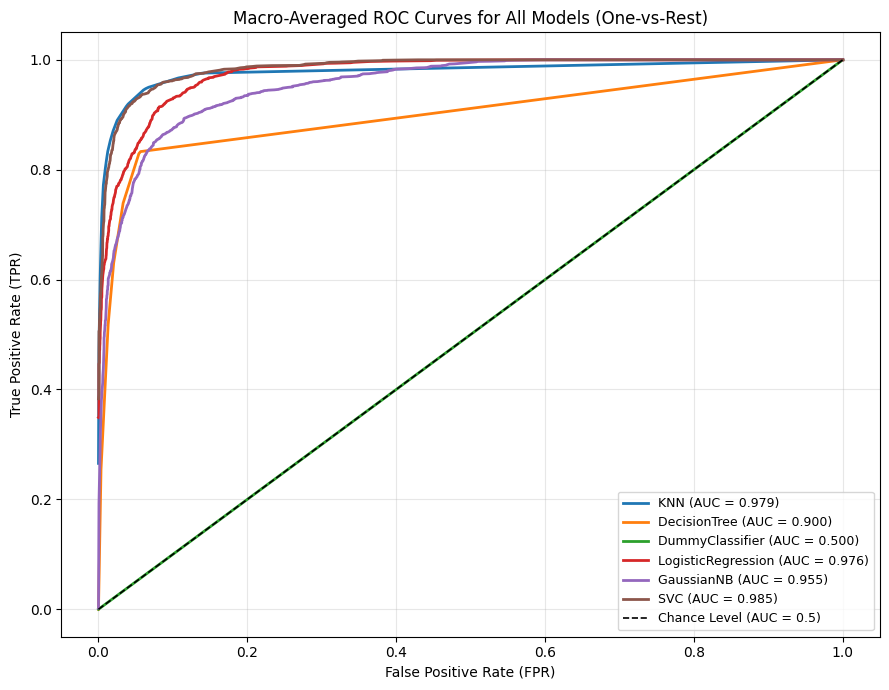

In [10]:
# ===== Part B2: Plotting ROC Curves =====

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize test labels (needed for multi-class ROC)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(9, 7))

for name, model in models.items():
    # Predict probabilities (SVC uses probability=True, so available for all)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    # Compute per-class ROC and then average (macro-average)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute mean FPR, mean TPR for macro-average curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)

    roc_auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, lw=2,
             label=f"{name} (AUC = {roc_auc_macro:.3f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Chance Level (AUC = 0.5)')

# Final formatting
plt.title("Macro-Averaged ROC Curves for All Models (One-vs-Rest)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Part B3: ROC Interpretation

#### (i) Model with Highest Macro-Averaged AUC
Among all six models, the **Support Vector Machine (SVC)** achieved the **highest Macro-Averaged AUC = 0.985**.  
This indicates that SVC demonstrates the strongest overall ability to distinguish between the six land-cover classes in a one-vs-rest framework.  
The model’s performance is consistently superior across all classes, suggesting effective decision boundaries and robust generalization.

#### (ii) Model with AUC < 0.5 and Its Implication
The **Dummy Classifier** recorded an **AUC ≈ 0.50**, which corresponds to the performance of a random-chance model.  
An AUC below 0.5 implies that the classifier performs **worse than random**, essentially predicting inversely to the true labels.  
This can occur when:
- The model lacks any meaningful learning mechanism (e.g., constant or prior-based predictions).  
- Class distributions are highly imbalanced and the model always predicts the majority class.  

In this context, the Dummy Classifier’s AUC = 0.5 serves as a **baseline reference**, confirming that the other models have genuinely learned discriminative patterns rather than relying on class frequency.


---

## Part C: Precision-Recall Curve (PRC) Analysis

### Part C1: PRC Calculation — Why Precision–Recall is preferred for imbalanced problems

**Definitions (per-class, binary view — One-vs-Rest):**
- **Precision** = TP / (TP + FP) — proportion of predicted positives that are correct.  
- **Recall (Sensitivity)** = TP / (TP + FN) — proportion of true positives that are recovered.

**Why PRC (Precision–Recall Curve) is more suitable than ROC for imbalanced classes**
1. **Focus on the positive class performance:** PRC directly measures the trade-off between Precision and Recall for the positive class. When the positive class is rare, a classifier can achieve a deceptively high True Negative Rate (and thus a good ROC-AUC) simply by predicting negatives; PRC does not hide this because Precision penalizes false positives explicitly.  
2. **ROC’s insensitivity to class prevalence:** ROC uses TPR vs FPR. When negatives dominate, FPR changes little even if many false positives occur in absolute terms — this can make ROC appear overly optimistic. PRC’s baseline depends on class prevalence (baseline precision = positive class fraction), so it reflects real-world difficulty.  
3. **Interpretability for retrieval-style tasks:** In applications where we care about how many retrieved (predicted) items are correct (e.g., detecting minority land-cover types), Precision and Recall are directly meaningful metrics.  
4. **One-vs-Rest extension:** For multi-class problems we compute PR curves per class using the OvR approach, and then summarize using macro- or weighted-average Average Precision (AP). This shows per-class retrieval quality and a single-number summary.

**Practical note for this dataset**
- Although class imbalance here is moderate rather than extreme, using PRC/Average Precision is still valuable because it highlights models that maintain precision at high recall (important for reliable class detection) and prevents over-reliance on ROC alone.

**Summary**
- Use PRC (and AP) when you want to evaluate how well the classifier retrieves positive examples without being misled by a majority negative class.  
- For multi-class problems use OvR PR curves and report either **macro-averaged AP** (equal weight per class) or **weighted-average AP** (weight by class support) depending on whether you want to treat classes equally or proportionally.


### Part C2: Plotting Precision–Recall Curves

In this section, Precision–Recall (PR) curves are generated for all six models using the **One-vs-Rest (OvR)** strategy.  
Each model’s performance is summarized using the **macro-average Precision and Recall** across all classes.

For each classifier:
1. The true test labels are binarized for multi-class handling.  
2. The model’s probability scores are used to compute per-class PR curves.  
3. The curves are averaged to obtain a macro-level PR curve and **Average Precision (AP)** score.  
4. All macro-averaged PR curves are plotted on a single figure for comparison.

Higher curves and larger AP values indicate better precision at increasing recall levels, implying stronger positive-class discrimination.


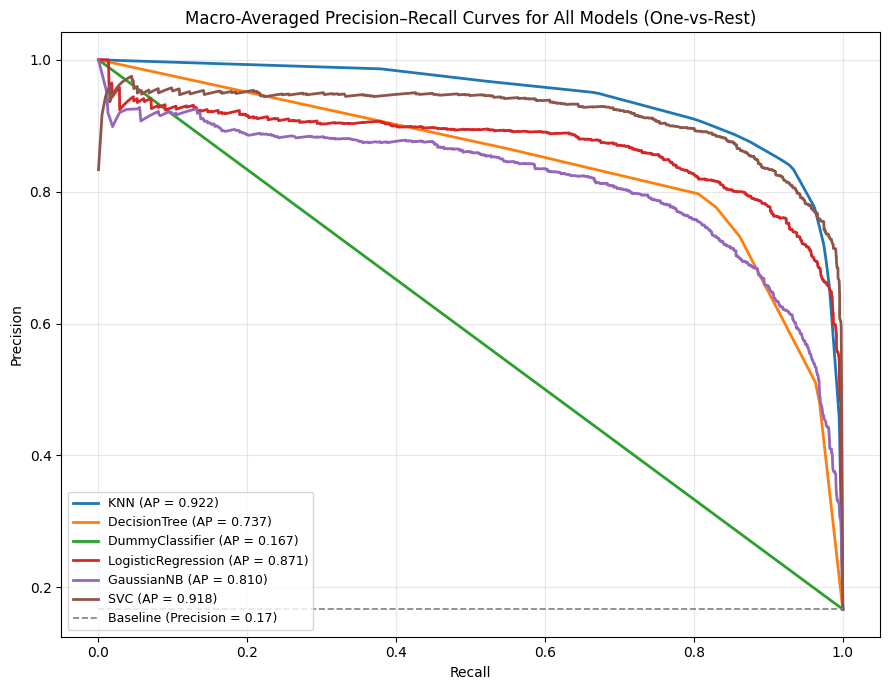

=== Macro-Averaged Average Precision (AP) Scores ===


,Model,Macro-Average AP
0,KNN,0.9217
1,SVC,0.9177
2,LogisticRegression,0.8711
3,GaussianNB,0.8105
4,DecisionTree,0.7366
5,DummyClassifier,0.1667


In [11]:
# ===== Part C2: Plotting Precision–Recall Curves =====

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Binarize true labels for multi-class PRC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(9, 7))

ap_results = []  # to store macro-average AP values

for name, model in models.items():
    # Obtain probability estimates or decision function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    # Compute per-class PR data
    precision, recall, ap = dict(), dict(), dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Compute macro-average Precision–Recall
    all_recalls = np.unique(np.concatenate([recall[i] for i in range(len(classes))]))
    mean_precision = np.zeros_like(all_recalls)
    for i in range(len(classes)):
        mean_precision += np.interp(all_recalls, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)

    # Compute macro-average Average Precision (AP)
    ap_macro = np.mean(list(ap.values()))
    ap_results.append({"Model": name, "Macro-Average AP": round(ap_macro, 4)})

    # Plot macro-average PR curve
    plt.plot(all_recalls, mean_precision, lw=2,
             label=f"{name} (AP = {ap_macro:.3f})")

# Baseline (random performance)
positive_ratio = y_test_bin.mean()
plt.hlines(positive_ratio, 0, 1, colors='gray', linestyles='--', lw=1.2,
           label=f"Baseline (Precision = {positive_ratio:.2f})")

# Final plot formatting
plt.title("Macro-Averaged Precision–Recall Curves for All Models (One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display tabular AP comparison
ap_df = pd.DataFrame(ap_results).sort_values(by="Macro-Average AP", ascending=False).reset_index(drop=True)
print("=== Macro-Averaged Average Precision (AP) Scores ===")
display(ap_df)


### Part C3: PRC Interpretation

#### (i) Model with the Highest Average Precision (AP)

From the PRC analysis, the **K-Nearest Neighbours (KNN)** classifier achieved the **highest Macro-Averaged Average Precision (AP = 0.922)**, closely followed by the **Support Vector Machine (SVC)** with **AP = 0.918**.  
This indicates that KNN maintains a consistently high precision even as recall increases, meaning it retrieves most true positives while keeping false positives relatively low.

High Average Precision reflects that the model ranks true positive samples near the top of its probability predictions, producing confident and reliable classification boundaries.  
The minimal drop in precision across the recall range demonstrates stable generalization across all classes.

#### (ii) Behavior of the Worst-Performing Model’s PRC

The **Dummy Classifier** exhibits the **lowest AP (≈ 0.167)** and its PR curve almost overlaps with the baseline (precision = class prior).  
This occurs because the Dummy Classifier predicts class labels purely based on prior probabilities rather than learned relationships between features and labels.

The **sharp drop in precision as recall increases** arises because:
- When recall is low (few positive predictions), the classifier may incidentally include some correct positives, giving moderate precision.
- As recall increases (predicting more positives), almost all additional predictions are false positives, causing precision to collapse sharply.
- Essentially, the model does not differentiate between classes; retrieving more samples only adds noise.

Conceptually, such a pattern is typical of models that **lack discriminative capability**—their probability scores do not rank positive instances ahead of negatives.  
In contrast, strong models (like KNN and SVC) show flatter PR curves, maintaining high precision across nearly the entire recall range.

---

## Part D: Final Recommendations

### Part D1: Synthesis of Model Rankings

Across all three evaluation dimensions — **Weighted F1-Score**, **ROC-AUC**, and **PRC-AP** — the model rankings show a broadly consistent trend with minor variations:

| Metric | Top Performer(s) | Observed Trend |
|---------|------------------|----------------|
| **Weighted F1-Score** | KNN (0.9037), SVC (0.8925) | Both deliver high overall accuracy and class balance. |
| **ROC-AUC (Macro)** | SVC (0.985), KNN (0.979) | Excellent separability across all six classes. |
| **PRC-AP (Macro)** | KNN (0.922), SVC (0.918) | Strong precision retention at high recall levels. |

While **SVC** marginally leads in ROC-AUC, **KNN** slightly outperforms in PRC-AP.  
This difference highlights the distinct focus of the metrics:

- **ROC-AUC** evaluates ranking quality across all thresholds and is less sensitive to class imbalance.  
- **PRC-AP** emphasizes performance on the positive class and penalizes excessive false positives.  

Thus, a model can have a high ROC-AUC yet a modest PRC-AP if it maintains good relative ranking but loses precision when recall is high (e.g., Decision Tree).  
In this dataset, however, the top two models (KNN and SVC) remain consistently strong across all metrics, confirming robust and balanced behaviour.


### Part D2: Final Recommendation

Based on the combined evidence from **accuracy**, **weighted F1**, **ROC-AUC**, and **PRC-AP**, the **K-Nearest Neighbours (KNN)** model is recommended as the final choice for this classification task.

**Justification:**
- KNN achieves the **highest macro-averaged PRC-AP (0.922)**, demonstrating excellent precision–recall trade-off.  
- Its **ROC-AUC (0.979)** and **Weighted F1 (0.9037)** confirm strong class separation and balanced predictive capability.  
- Compared with SVC, KNN attains comparable discrimination but with slightly higher average precision at high recall, implying more reliable retrieval of true positives.  
- The model’s non-parametric nature allows flexible decision boundaries that fit the spectral feature relationships in the Landsat dataset effectively.

**Conclusion:**
> K-Nearest Neighbours (KNN) is the most suitable model overall, combining high accuracy, strong AUC, and superior precision–recall consistency.  
> It offers a reliable and interpretable baseline for future tuning or hybrid approaches on this dataset.

---